# Seq2Seq_Attension
刪除原數列中的奇數數字並將剩餘偶數數字複製一次
<br>輸入 : [9 , 4 , 1 , 4 , 8 , 5 , 8 , 3 , 7 , 5 , 8 , 10 , 5]
<br>輸出 : [4 , 4 , 8 , 8 , 8 , 10 , 4 , 4 , 8 , 8 , 8 , 10]

本程式試著不使用Tensorflow所提供的Helper指令，完成Scheduled Sampling<br>
Scheduled Sampling是一種解決訓練和生成時輸入數據分布不一致的方法<br>

在一般的Seq2Seq模型的inference階段中，如果Sequence中在t時刻中產生錯誤的值，在t時刻之後的輸入狀態將會受到影響，而該誤差會隨著生成過程不斷向後累積；而Scheduled Sampling以一定概率將Decoder自己產生的值作為Decoder端的輸入，這樣即使前面產生錯誤的值，其目標仍然是最大化真實目標序列的概率，模型會朝著正確的方向進<br>

在訓練早期Scheduled Sampling主要使用target中的真實值作為Decoder端的輸入，可以將模型從隨機初始化的狀態快速引導至一個合理的狀態；隨著訓練的進行，該方法會逐漸更多地使用Decoder自己產生的值作為Decoder端的輸入，以解決數據分布不一致的問題<br>

<img src="3_scheduled_sampling_不使用helper指令_version_1.jpg" style="width:1140px;height:600px;float:middle">
以上為Decoder端的計算流程

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Hyperameter

In [2]:
# 超參數
# Number of Epochs
epochs = 300
# RNN Size
rnn_hidden_unit = 50
# Attention Size
att_size = 40
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 15
decoding_embedding_size = rnn_hidden_unit
# Learning Rate
learning_rate = 0.001

vocab_size_sorce = 10 + 1  # 1~10 + 0
vocab_size_target = 10 + 3 # 1~10 + 0 & 11 &12
max_len = 24
source_max_length = 26 # 並沒有要使用動態長度，所以強迫把source補到26這個長度
target_max_length = 27 # 並沒有要使用動態長度，所以強迫把target補到26這個長度
epochs = 300
batch_iters = 100
batch_size = 64

## 準備數據(將數字串中的奇數刪除，並將剩下的數字再複製一遍)

In [3]:
PAD = 0
GO = 11
EOS = 12
odd_list, even_list = [1, 3, 5, 7, 9] * 10, [2, 4, 6, 8, 10] * 10

def get_batches(num_samples=batch_size, copy_sequence=True):  
    num_odds = np.random.randint(low=1, high=max_len//2, size=num_samples)
    num_evens = np.random.randint(low=1, high=max_len//2, size=num_samples)
    batch_len_x = num_odds + num_evens
    if copy_sequence:
        batch_len_y = num_evens * 2 + 1  # append <EOS> (or prepend <GO>)
    else:
        batch_len_y = num_evens + 1  # append <EOS> (or prepend <GO>)

    batch_max_length_x = np.max(batch_len_x)
    batch_max_length_y = np.max(batch_len_y)

    batch_data_x, batch_data_y = [], []
    for i in range(num_samples):
        odds = random.sample(odd_list, num_odds[i])
        evens = random.sample(even_list, num_evens[i])
        sample_x = odds + evens
        random.shuffle(sample_x)

        sample_y = list(filter(lambda x: x % 2 == 0, sample_x))
        if copy_sequence:
            sample_y += sample_y
        sample_x = np.r_[sample_x, [PAD] * (batch_max_length_x - len(sample_x))]
        sample_y = np.r_[sample_y, [EOS] ,[PAD] * (batch_max_length_y - len(sample_y) - 1)]

        batch_data_x.append(sample_x)
        batch_data_y.append(sample_y)

    return batch_data_x , batch_data_y , batch_len_x , batch_len_y


# batch_data_x要補PAD到source_max_length
# batch_data_y要補PAD到target_max_length    
def post_process(batch_data_x , batch_data_y):  
    batch_data_x_ = []
    for seq in batch_data_x:
        seq = list(seq)
        while len(seq) < source_max_length:
            seq.append(PAD) 
        batch_data_x_.append(seq)  
    batch_data_x_ = np.array(batch_data_x_).astype(np.int32)    
    
    batch_data_y_ = []
    for seq in batch_data_y:
        seq = list(seq)
        while len(seq) < target_max_length:
            seq.append(PAD) 
        batch_data_y_.append(seq) 
    batch_data_y_ = np.array(batch_data_y_).astype(np.int32)     
    
    return batch_data_x_  , batch_data_y_     

## 輸入層

In [4]:
input_data = tf.placeholder(tf.int32, [None , source_max_length] , name = 'inputs')
targets = tf.placeholder(tf.int32, [None , target_max_length] , name = 'targets')
targets_onehot = tf.one_hot(tf.reshape(targets , [-1]) , depth = vocab_size_target)
lr = tf.placeholder(tf.float32 , name = 'learning_rate')

# 決定到底是"t-1階段的輸出"還是"target中的真實答案"，當作t階段的輸入
from_model_or_target = tf.placeholder(tf.bool , [target_max_length , ] , name = 'coin_tossing')

## Encoder

In [5]:
# Encoder embedding
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , source_vocab_size , encoding_embedding_size) 
                                                  ⇕ 相當於
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

若懶得寫兩行程式可以直接用tf.contrib.layers.embed_sequence這個函數
介紹 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , vocab_size_sorce , encoding_embedding_size)

# RNN cell
def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
    return lstm_cell

encoder_cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])

encoder_output, encoder_state = tf.nn.dynamic_rnn(encoder_cell , 
                                                  encoder_embed_input, 
                                                  dtype = tf.float32) # encoder_output → [batch_size , source_max_length , rnn_hidden_unit]

## Decoder and Attention

In [6]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上GO，並移除最後一個字，所以每一筆data的詞的數目並無改變
ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1], GO), ending], 1)

In [7]:
# 1. Embedding
decoder_embeddings = tf.Variable(tf.random_uniform([vocab_size_target , decoding_embedding_size]) , name = 'decoder_embeddings')
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

with tf.variable_scope('decoder'):
    # 2. 建構Decoder中的RNN
    decoder_cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])
    state = encoder_state
    final_outputs  = []
    attention_matrix = []
    for time_step in range(0 , target_max_length):
        if time_step > 0: tf.get_variable_scope().reuse_variables()    
            
        # 在訓練的過程中，除了time_step為0以外，每一個time_step都投擲硬幣決定
        # 要用decoder_embed_input[: , time_step , :](target中的真實答案)，還是mlstm_cell_output(machine自己產生的output)，輸入decoder_cell
        # 正面代表當前時刻decoder_cell要吃decoder_embed_input[: , time_step , :](target中的真實答案)
        # 反面代表當前時刻decoder_cell要吃mlstm_cell_output(上一個時刻decoder_cell的輸出)
        # 也就是coin tossing為[True , True , True , True , True , True , True , True]會逐漸變為[Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse]
        # 前幾個epoch會有很大的機率擲出正面，但隨著訓練的過程擲出反面的機率會越來越大
        # 在後面的步驟會調節擲出正反面的機率
        if time_step == 0:
            input_to_decoder = decoder_embed_input[: , 0 , :]
            mlstm_cell_output , state = decoder_cell(input_to_decoder , state)
                
        elif time_step > 0: 
            input_to_decoder = tf.cond(from_model_or_target[time_step] , 
                                       lambda: decoder_embed_input[: , time_step , :] , 
                                       lambda: context_vector)
            mlstm_cell_output , state = decoder_cell(input_to_decoder , state) # mlstm_cell_output → [batch_size , rnn_hidden_unit] 
        
        with tf.variable_scope('attention'):
            if time_step > 0: tf.get_variable_scope().reuse_variables() 
            W_1 = tf.get_variable(initializer = tf.truncated_normal([rnn_hidden_unit , att_size] , mean = 0.001 , stddev = 0.3) ,
                                  name = 'w_1') 
            W_2 = tf.get_variable(initializer = tf.truncated_normal([rnn_hidden_unit , att_size] , mean = 0.001 , stddev = 0.3) ,
                                  name = 'w_2')       
            V = tf.get_variable(initializer = tf.truncated_normal([att_size , 1] , mean = 0.001 , stddev = 0.3) , 
                                name = 'V')
            
            # a → [2 , 3 , 3] 
            # b → [3 , 2 , 6]
            # c = tf.tensordot(a , b , axes = 1)  → [2 , 3 , 2 , 6]
            score = tf.nn.tanh(tf.tensordot(encoder_output , W_1 , axes = 1) + \
                               tf.expand_dims(tf.tensordot(mlstm_cell_output , W_2 , axes = 1) , 1)) # score → [batch_size , source_max_length , att_size]     
            score = tf.tensordot(score , V , axes = 1) # score → [batch_size , source_max_length , 1]
            
            attention_weights = tf.nn.softmax(score , axis = 1) # attention_weights → [batch_size , source_max_length , 1]       
            context_vector = tf.multiply(attention_weights , encoder_output) # context_vector → [batch_size , source_max_length , rnn_hidden_unit]      
            context_vector = tf.reduce_sum(context_vector , axis = 1) # context_vector → [batch_size , rnn_hidden_unit]            

        final_outputs.append(context_vector)
        # tf.squeeze(attention_weights , [-1]) : [batch_size , source_max_length , 1] → [batch_size , source_max_length] 
        attention_matrix.append(tf.squeeze(attention_weights , [-1])) # 把每一個time_step的attention_weights收集起來成為attention_matrix

In [8]:
final_outputs_ = tf.transpose(tf.convert_to_tensor(final_outputs) , [1 , 0 , 2]) # final_outputs_ → [batch_size , target_max_length , rnn_hidden_unit]    
final_outputs_ = tf.reshape(final_outputs_ , [-1 , rnn_hidden_unit]) 

weights = tf.Variable(tf.truncated_normal([rnn_hidden_unit , vocab_size_target] , mean = 0.01 , stddev = 0.1))
biases = tf.Variable(tf.zeros([1 , vocab_size_target]) + 0.0001)
logits = tf.matmul(final_outputs_ , weights) + biases 

predicting_logits = tf.nn.softmax(logits , axis = 1)   
predicting_logits = tf.argmax(predicting_logits , axis = 1)
predicting_logits = tf.reshape(predicting_logits , [batch_size , -1] , name = 'predictions')
attention_matrix = tf.transpose(tf.convert_to_tensor(attention_matrix) , [1 , 2 , 0] , name = 'attention_weight') # attention_matrix => [batch_size , source_max_length , target_max_length]  

In [9]:
# Loss function
loss = tf.nn.softmax_cross_entropy_with_logits(labels = targets_onehot , logits = logits)
total_loss = tf.reduce_mean(loss)

# Optimizer
optimizer = tf.train.AdamOptimizer(lr)

# Gradient Clipping
gradients = optimizer.compute_gradients(total_loss)
capped_gradients = [(tf.clip_by_value(grad, -5., 5.) , var) \
                    for grad , var in gradients if grad is not None]
train_op = optimizer.apply_gradients(capped_gradients)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

prob = 1e-3
alpha = 1.1
stop_early = 0
for epoch_i in range(0 , epochs):
    
    # 一開始會出現[True , True , True , True , True , True , True , True]
    # 隨著epoch的增長，逐漸開始出現[Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse]
    # 在Decoder端的訓練，一開始t階段的輸入為t-1階段的期望輸出(Teacher Forcing)，到最後逐漸變為t階段的輸入為t-1階段的輸出(Sampling)
    coin_tossing = np.random.choice(a = 2 , 
                                    size = target_max_length , 
                                    replace = True , 
                                    p = [prob , 1 - prob])
    coin_tossing = coin_tossing.astype(bool)
    if alpha * prob < 1  : prob = alpha * prob
    elif alpha * prob > 1: prob = 1. 
    
    for batch_i in range(0 , batch_iters):
        
        train_source_batch , train_target_batch , _ , train_target_length = get_batches()
        train_source_batch , train_target_batch = post_process(train_source_batch , train_target_batch)
    
        _ , training_loss , predicting_logits_result =\
        sess.run([train_op, total_loss , predicting_logits], 
                 feed_dict = {input_data : train_source_batch ,
                              targets : train_target_batch ,
                              from_model_or_target : coin_tossing ,
                              lr: learning_rate})
            
        if batch_i % 50 == 0:   
            validation_source_batch , validation_target_batch , _ , _ = get_batches()
            validation_source_batch , validation_target_batch = post_process(validation_source_batch , validation_target_batch)   
            validation_loss = sess.run(total_loss , 
                                       feed_dict = {input_data :  validation_source_batch ,
                                                    targets : validation_target_batch ,
                                                    from_model_or_target : coin_tossing}) 

            print('Epoch : {}/{} \nBatch : {}/{} \nTraining Loss : {:.3f} \nValidation loss: {:.3f} \nstop_early : {} \ncoin_tossing : {}'
                  .format(epoch_i , epochs , 
                          batch_i , batch_iters , 
                          training_loss , validation_loss , 
                          stop_early , coin_tossing))

            print('Source : {}'.format(train_source_batch[0 , :]))
            print('Target : {}'.format(train_target_batch[0 , :]))
            print('Predict : {}\n'.format(predicting_logits_result[0 , :]))
            
    if coin_tossing.sum() == 0:
        stop_early += 1

    if stop_early == 200: # 當coin_tossing全部為False的次數為200時即停止計算
        break        

Epoch : 0/300 
Batch : 0/100 
Training Loss : 2.566 
Validation loss: 2.560 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [2 8 3 6 9 3 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 2  8  6  2  8  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]

Epoch : 0/300 
Batch : 50/100 
Training Loss : 1.302 
Validation loss: 1.430 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 4  4  4 10  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 4  4  4 10  2  2  4  4  4 10  2  2 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Epoch : 8/300 
Batch : 0/100 
Training Loss : 0.575 
Validation loss: 0.694 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [4 7 1 1 5 5 4 4 1 3 4 9 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 4  4  4  4  4  4  4  4 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 4  4  4  4  4  4  4 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 8/300 
Batch : 50/100 
Training Loss : 0.666 
Validation loss: 0.582 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 1  1  4  6  3  5  8  2  6  4  5 10  1  7  5 10  0  0  0  0  0  0  0  0
  0  0]
Target : [ 4  6  8  2  6  4 10 10  4  6  8  2  6  4 10 10 12  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 4  4 

Epoch : 16/300 
Batch : 0/100 
Training Loss : 0.301 
Validation loss: 0.327 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True]
Source : [ 1  1  8  5  8  9  2  3  4  4 10  2  5  1  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  8  2  4  4 10  2  8  8  2  4  4 10  2 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 8  8  6  4  4 10  2  8  8  6  4  4 10  2 12  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 16/300 
Batch : 50/100 
Training Loss : 0.480 
Validation loss: 0.326 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True]
Source : [ 8  2  8  2  9  1  4  3 10  6  7  5  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  2  8  2  4 10  6  8  2  8  2  4 10  6 12  0  0  0  0  0  0  0  0  0

Epoch : 24/300 
Batch : 0/100 
Training Loss : 0.048 
Validation loss: 0.035 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 2  3  8 10  5 10  4  5  6  2  7  7  7  9  4  5  6  5 10  0  0  0  0  0
  0  0]
Target : [ 2  8 10 10  4  6  2  4  6 10  2  8 10 10  4  6  2  4  6 10 12  0  0  0
  0  0  0]
Predict : [ 2  8 10 10  4  6  2  2  6 10  2  8 10 10  4  6  2  4  6 10 12  0  0  0
  0  0  0]

Epoch : 24/300 
Batch : 50/100 
Training Loss : 0.029 
Validation loss: 0.036 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 3  5 10  9  8  9  3  7  1  2  9  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  8  2 10  8  2 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Epoch : 32/300 
Batch : 0/100 
Training Loss : 0.011 
Validation loss: 0.009 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 8 10 10  4  6  4  5 10  5 10  9 10  7  2  8  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8 10 10  4  6  4 10 10 10  2  8  8 10 10  4  6  4 10 10 10  2  8 12  0
  0  0  0]
Predict : [ 8 10 10  4  6  4 10 10 10  2  8  8 10 10  4  6  4 10 10 10  2  8 12  0
  0  0  0]

Epoch : 32/300 
Batch : 50/100 
Training Loss : 0.008 
Validation loss: 0.006 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 6  6  8  2  5  5 10  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  6  8  2 10  6  6  6  8  2 10  6 12  0  0  0  0  0  0  0  0  0  0  0

Epoch : 39/300 
Batch : 50/100 
Training Loss : 0.026 
Validation loss: 0.035 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [ 8  4  2  2  4  9  5  5 10  2  7  8  4  4  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  4  2  2  4 10  2  8  4  4  8  4  2  2  4 10  2  8  4  4 12  0  0  0
  0  0  0]
Predict : [ 8  4  2  2  4 10  2  8  4  4  8  4  2  2  4 10  2  8  4  4 12  0  0  0
  0  0  0]

Epoch : 40/300 
Batch : 0/100 
Training Loss : 0.089 
Validation loss: 0.120 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Source : [10  7  2  2  1 10  6  2  9  3  9  4  1  7 10 10  5  0  0  0  0  0  0  0
  0  0]
Target : [10  2  2 10  6  2  4 10 10 10  2  2 10  6  2  4 10 10 12  0  0  0  0  0

Epoch : 47/300 
Batch : 0/100 
Training Loss : 0.004 
Validation loss: 0.003 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True]
Source : [10  8  6  6  9  4  8  2  6  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  8  6  6  4  8  2  6  4 10  8  6  6  4  8  2  6  4 12  0  0  0  0  0
  0  0  0]
Predict : [10  8  6  6  4  8  2  6  4 10  8  6  6  4  8  2  6  4 12  0  0  0  0  0
  0  0  0]

Epoch : 47/300 
Batch : 50/100 
Training Loss : 0.004 
Validation loss: 0.003 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True]
Source : [1 4 9 5 6 9 8 9 1 5 6 6 8 9 3 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 4  6  8  6  6  8  4  6  8  6  6  8 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 4  

Epoch : 54/300 
Batch : 50/100 
Training Loss : 0.176 
Validation loss: 0.279 
stop_early : 0 
coin_tossing : [ True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True]
Source : [1 3 1 6 7 7 8 4 6 8 6 9 8 2 8 4 1 5 2 0 0 0 0 0 0 0]
Target : [ 6  8  4  6  8  6  8  2  8  4  2  6  8  4  6  8  6  8  2  8  4  2 12  0
  0  0  0]
Predict : [ 6  8  4  6  8  6  8  8  8  4  2  6  8  8  6  8  6  8  8  8  8  2 12  0
  0  0  0]

Epoch : 55/300 
Batch : 0/100 
Training Loss : 0.062 
Validation loss: 0.052 
stop_early : 0 
coin_tossing : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True]
Source : [ 7  6  8  9 10  1  4  8 10  9  7  5  5  8  6  2  2  0  0  0  0  0  0  0
  0  0]
Target : [ 6  8 10  4  8 10  8  6  2  2  6  8 10  4  8 10  8  6  2  2 12  0  0  0
  0  0  0]
Predict : [ 6  

Epoch : 62/300 
Batch : 50/100 
Training Loss : 0.025 
Validation loss: 0.021 
stop_early : 0 
coin_tossing : [ True False False  True  True  True  True  True False  True False  True
  True False  True False  True  True  True False  True  True  True  True
  True  True False]
Source : [ 8  2 10  8  7  5  4  6  7  9  4  1  8  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  2 10  8  4  6  4  8  8  2 10  8  4  6  4  8 12  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 8  2 10  8  4  6  4  8  8  2 10  8  4  6  4  8 12  0  0  0  0  0  0  0
  0  0  0]

Epoch : 63/300 
Batch : 0/100 
Training Loss : 0.011 
Validation loss: 0.010 
stop_early : 0 
coin_tossing : [ True False  True  True False  True  True  True  True  True False  True
  True False False  True  True  True  True False False  True  True False
 False  True False]
Source : [ 6  2  8  9  8  8  7  9  1  5  4  4  6 10  4  3  2  9  1  0  0  0  0  0
  0  0]
Target : [ 6  2  8  8  8  4  4  6 10  4  2  6  2  8  8  8  4  4  6 10  4  2 12  0

Epoch : 70/300 
Batch : 0/100 
Training Loss : 0.005 
Validation loss: 0.004 
stop_early : 0 
coin_tossing : [False False False False False False False  True  True False False False
 False False False  True False False  True  True False False False False
  True False False]
Source : [ 2  8  3  9  2  6  9 10  5  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 2  8  2  6 10  6  2  8  2  6 10  6 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2  8  2  6 10  6  2  8  2  6 10  6 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 70/300 
Batch : 50/100 
Training Loss : 0.296 
Validation loss: 0.292 
stop_early : 0 
coin_tossing : [False False False False False False False  True  True False False False
 False False False  True False False  True  True False False False False
  True False False]
Source : [ 2  4  9  9  1  4  1  9  8  5  7  2  5 10  2 10  6  7  1  0  0  0  0  0
  0  0]
Target : [ 2  4  4  8  2 10  2 10  6  2  4  4  8  2 10  2 10  6 12  0  0  0  0  0

Epoch : 78/300 
Batch : 0/100 
Training Loss : 0.002 
Validation loss: 0.002 
stop_early : 5 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 3 10  9  6 10 10  8  6  8  6  2  8  6  5  1  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  6 10 10  8  6  8  6  2  8  6 10  6 10 10  8  6  8  6  2  8  6 12  0
  0  0  0]
Predict : [10  6 10 10  8  6  8  6  2  8  6 10  6 10 10  8  6  8  6  2  8  6 12  0
  0  0  0]

Epoch : 78/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.002 
stop_early : 5 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7 10  3  9  5  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Epoch : 85/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 12 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 4  2  2 10  5  8  6 10  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 4  2  2 10  8  6 10  4  4  2  2 10  8  6 10  4 12  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 4  2  2 10  8  6 10  4  4  2  2 10  8  6 10  4 12  0  0  0  0  0  0  0
  0  0  0]

Epoch : 86/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 13 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7  8  6  6  7 10  3  4  1  8  2  2  9  8 10  8  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  6  6 10  4  8  2  2  8 10  8  8  6  6 10  4  8  2  2  8 10  8 12 

Epoch : 93/300 
Batch : 0/100 
Training Loss : 0.002 
Validation loss: 0.003 
stop_early : 20 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 8  4 10  6  2  6  2  6  9  6 10  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  4 10  6  2  6  2  6  6 10  2  8  4 10  6  2  6  2  6  6 10  2 12  0
  0  0  0]
Predict : [ 8  4 10  6  2  6  2  6  6 10  2  8  4 10  6  2  6  2  6  6 10  2 12  0
  0  0  0]

Epoch : 93/300 
Batch : 50/100 
Training Loss : 0.002 
Validation loss: 0.002 
stop_early : 20 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 6  4  6 10 10  1  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  4  6 10 10  2  6  4  6 10 10  2 12  0  0  0  0  0  0  0  0  0  0 

Epoch : 100/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 27 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [2 2 4 1 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 2  2  4  6  2  2  4  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2  2  4  6  2  2  4  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 101/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 28 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [8 3 1 5 1 8 1 9 7 6 3 2 3 8 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 8  8  6  2  8  8  8  6  2  8 12  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 8  8  6  2  8  8  8  6  2 

Epoch : 108/300 
Batch : 0/100 
Training Loss : 0.000 
Validation loss: 0.000 
stop_early : 35 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 5  3  6 10  8  5  7  2  6  8  9  6  6  2  4  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6 10  8  2  6  8  6  6  2  4  6 10  8  2  6  8  6  6  2  4 12  0  0  0
  0  0  0]
Predict : [ 6 10  8  2  6  8  6  6  2  4  6 10  8  2  6  8  6  6  2  4 12  0  0  0
  0  0  0]

Epoch : 108/300 
Batch : 50/100 
Training Loss : 0.000 
Validation loss: 0.000 
stop_early : 35 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 6  8 10  4  2 10 10  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  8 10  4  2 10 10  4  6  8 10  4  2 10 10  4 12  0  0  0  0  0  

Epoch : 115/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.002 
stop_early : 42 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 3  5  6  4  2  7  3  8 10  8  7  7  5  9  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  4  2  8 10  8  6  4  2  8 10  8 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6  4  2  8 10  8  6  4  2  8 10  8 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 116/300 
Batch : 0/100 
Training Loss : 0.002 
Validation loss: 0.003 
stop_early : 43 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [6 4 6 5 2 9 3 2 4 6 5 2 4 3 6 5 8 0 0 0 0 0 0 0 0 0]
Target : [ 6  4  6  2  2  4  6  2  4  6  8  6  4  6  2  2  4  6  2  4  6  8 12  0
  0  0  0]
Predict : [

Epoch : 123/300 
Batch : 0/100 
Training Loss : 0.061 
Validation loss: 0.087 
stop_early : 50 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [9 7 5 3 3 1 9 6 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 6  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 123/300 
Batch : 50/100 
Training Loss : 0.009 
Validation loss: 0.009 
stop_early : 50 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 1  4 10  9  3  3  2  4  1  3  9  6 10  4  1  1  5  6  8  0  0  0  0  0
  0  0]
Target : [ 4 10  2  4  6 10  4  6  8  4 10  2  4  6 10  4  6  8 12  0  0  0  0  0
  0  0  0]
Predict : [

Epoch : 131/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 58 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 1  5  7  6  4  8  4 10  2  5  6  6  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  4  8  4 10  2  6  6  6  4  8  4 10  2  6  6 12  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6  4  8  4 10  2  6  6  6  4  8  4 10  2  6  6 12  0  0  0  0  0  0  0
  0  0  0]

Epoch : 131/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 58 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [2 9 9 9 3 1 5 3 5 1 7 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 2  8  2  8 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [

Epoch : 138/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.002 
stop_early : 65 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 2  5  1  7 10  1  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 2 10  2 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2 10  2 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 139/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 66 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7  1  5 10  9  7  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

Epoch : 146/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.000 
stop_early : 73 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 9  2  6  8  9 10  8  7  4  9  9 10  5  5  1  2  6  6  3  0  0  0  0  0
  0  0]
Target : [ 2  6  8 10  8  4 10  2  6  6  2  6  8 10  8  4 10  2  6  6 12  0  0  0
  0  0  0]
Predict : [ 2  6  8 10  8  4 10  2  6  6  2  6  8 10  8  4 10  2  6  6 12  0  0  0
  0  0  0]

Epoch : 146/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.000 
stop_early : 73 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 1  5  6  8 10  7 10  2  7  4  9  6  6  1  4  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  8 10 10  2  4  6  6  4  6  8 10 10  2  4  6  6  4 12  0  0  0  

Epoch : 154/300 
Batch : 0/100 
Training Loss : 0.002 
Validation loss: 0.002 
stop_early : 81 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 9  9  8  8  2  6  8  3 10 10  2  6  2 10  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  8  2  6  8 10 10  2  6  2 10  8  8  2  6  8 10 10  2  6  2 10 12  0
  0  0  0]
Predict : [ 8  8  2  6  8 10 10  2  6  2 10  8  8  2  6  8 10 10  2  6  2 10 12  0
  0  0  0]

Epoch : 154/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 81 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [8 9 7 5 5 9 5 2 8 2 3 8 9 1 9 1 8 8 0 0 0 0 0 0 0 0]
Target : [ 8  2  8  2  8  8  8  8  2  8  2  8  8  8 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [

Epoch : 162/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.000 
stop_early : 89 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 2  3  3  4 10  9  2  2  2  6  9  6  2  6  3  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 2  4 10  2  2  2  6  6  2  6  2  4 10  2  2  2  6  6  2  6 12  0  0  0
  0  0  0]
Predict : [ 2  4 10  2  2  2  6  6  2  6  2  4 10  2  2  2  6  6  2  6 12  0  0  0
  0  0  0]

Epoch : 162/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.000 
stop_early : 89 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [5 9 8 5 9 8 6 6 6 8 3 7 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 8  8  6  6  6  8  8  8  6  6  6  8 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [

Epoch : 169/300 
Batch : 50/100 
Training Loss : 0.112 
Validation loss: 0.070 
stop_early : 96 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7  1 10  5  5  1  6 10  1  7  5 10 10  1  8 10  4  4  6 10  0  0  0  0
  0  0]
Target : [10  6 10 10 10  8 10  4  4  6 10 10  6 10 10 10  8 10  4  4  6 10 12  0
  0  0  0]
Predict : [10  6 10 10 10  8  4  4 10 10 10 10  6 10 10 10 10 10  4  4 10 12  0  0
  0  0  0]

Epoch : 170/300 
Batch : 0/100 
Training Loss : 0.015 
Validation loss: 0.021 
stop_early : 97 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 8  5  5  4  9  1  8  9  7  8  1 10  5  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  4  8  8 10  8  4  8  8 10 12  0  0  0  0  0  0  0  0  0  0  0  

Epoch : 177/300 
Batch : 0/100 
Training Loss : 0.002 
Validation loss: 0.003 
stop_early : 104 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [1 6 6 9 5 9 6 1 2 5 6 4 4 1 9 1 0 0 0 0 0 0 0 0 0 0]
Target : [ 6  6  6  2  6  4  4  6  6  6  2  6  4  4 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6  6  6  2  6  4  4  6  6  6  2  6  4  4 12  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 177/300 
Batch : 50/100 
Training Loss : 0.002 
Validation loss: 0.001 
stop_early : 104 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 9 10  4  7  2  7 10  1  8  5  2  3  7  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  4  2 10  8  2 10  4  2 10  8  2 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict :

Epoch : 185/300 
Batch : 0/100 
Training Loss : 0.097 
Validation loss: 0.116 
stop_early : 112 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 9  5  1  6 10  3  7  5  1  9  3  8  8  4  4  8  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6 10  8  8  4  4  8  6 10  8  8  4  4  8 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6 10  8  8  4  4  8  6 10  8  8  4  4  4 12  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 185/300 
Batch : 50/100 
Training Loss : 0.031 
Validation loss: 0.034 
stop_early : 112 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [10  4  5  8  8  4  2  4  6  3  7  9 10 10  7  2  0  0  0  0  0  0  0  0
  0  0]
Target : [10  4  8  8  4  2  4  6 10 10  2 10  4  8  8  4  2  4  6 10 10  2

Epoch : 192/300 
Batch : 50/100 
Training Loss : 0.005 
Validation loss: 0.005 
stop_early : 119 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [7 2 5 1 1 6 3 4 9 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 2  6  4  2  6  4 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2  6  4  2  6  4 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 193/300 
Batch : 0/100 
Training Loss : 0.012 
Validation loss: 0.022 
stop_early : 120 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 8  1 10  4  7  5  8  7  7  2  6  9  7  6  9  8  8  6  4  0  0  0  0  0
  0  0]
Target : [ 8 10  4  8  2  6  6  8  8  6  4  8 10  4  8  2  6  6  8  8  6  4 12  0
  0  0  0]
Predict :

Epoch : 200/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 127 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 6  2  6  8  8 10 10  9  4  4  4  9  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  2  6  8  8 10 10  4  4  4  6  2  6  8  8 10 10  4  4  4 12  0  0  0
  0  0  0]
Predict : [ 6  2  6  8  8 10 10  4  4  4  6  2  6  8  8 10 10  4  4  4 12  0  0  0
  0  0  0]

Epoch : 200/300 
Batch : 50/100 
Training Loss : 0.002 
Validation loss: 0.001 
stop_early : 127 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [6 5 7 9 1 5 6 9 7 3 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 6  6  6  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict :

Epoch : 207/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 134 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [9 2 8 9 6 1 5 1 7 6 6 5 4 3 9 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 2  8  6  6  6  4  2  8  6  6  6  4 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2  8  6  6  6  4  2  8  6  6  6  4 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 208/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 135 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 6 10  2  1  8  9  3 10  5  1  4  1  9  2  7 10  3  3  9  8  4  8  0  0
  0  0]
Target : [ 6 10  2  8 10  4  2 10  8  4  8  6 10  2  8 10  4  2 10  8  4  8 12  0
  0  0  0]
Predict :

Epoch : 215/300 
Batch : 0/100 
Training Loss : 0.121 
Validation loss: 0.125 
stop_early : 142 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [6 4 2 8 1 1 2 4 9 2 5 2 8 9 1 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 6  4  2  8  2  4  2  2  8  6  4  2  8  2  4  2  2  8 12  0  0  0  0  0
  0  0  0]
Predict : [ 6  4  2  8  2  4  2  2  8  6  2  2  2  2  2  2  2  8 12  0  0  0  0  0
  0  0  0]

Epoch : 215/300 
Batch : 50/100 
Training Loss : 0.033 
Validation loss: 0.034 
stop_early : 142 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 1  5 10  9  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  8 10  8 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict :

Epoch : 223/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.002 
stop_early : 150 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7  2  5  7  5  4  5  1  9  8  6  3  6  7 10  8  0  0  0  0  0  0  0  0
  0  0]
Target : [ 2  4  8  6  6 10  8  2  4  8  6  6 10  8 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 2  4  8  6  6 10  8  2  4  8  6  6 10  8 12  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 223/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 150 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 3  2  8  9  9  4 10  5  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 2  8  4 10  2  8  4 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0

Epoch : 231/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 158 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 3  1  3  5  6  7  9  8  2 10  7  6  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 6  8  2 10  6  6  8  2 10  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 6  8  2 10  6  6  8  2 10  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 231/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 158 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [4 3 9 3 2 5 8 4 7 6 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 4  2  8  4  6  4  2  8  4  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict :

Epoch : 238/300 
Batch : 50/100 
Training Loss : 0.007 
Validation loss: 0.005 
stop_early : 165 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [10 10  7  7  3  7  5  7 10  5  9  7  5  9  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10 10 10 10 10 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [10 10 10 10 10 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 239/300 
Batch : 0/100 
Training Loss : 0.004 
Validation loss: 0.004 
stop_early : 166 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 4  4  7  9 10  6  1  2  1  1  5  5  5  2  8  3  5  9  0  0  0  0  0  0
  0  0]
Target : [ 4  4 10  6  2  2  8  4  4 10  6  2  2  8 12  0  0  0  0  0  0  0

Epoch : 246/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 173 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 7  3  8  9  5  7  3  5 10  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8 10  8 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 8 10  8 10 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 246/300 
Batch : 50/100 
Training Loss : 0.396 
Validation loss: 2.057 
stop_early : 173 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 4  1  3  5  7  9  4  7  9  9  4  8  6 10  7  8  7  0  0  0  0  0  0  0
  0  0]
Target : [ 4  4  4  8  6 10  8  4  4  4  8  6 10  8 12  0  0  0  0  0  0  0

Epoch : 253/300 
Batch : 50/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 180 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [4 6 1 8 5 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 4  6  8  4  6  8 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [ 4  6  8  4  6  8 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 254/300 
Batch : 0/100 
Training Loss : 0.001 
Validation loss: 0.001 
stop_early : 181 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 8  4 10  6 10  3  3  1  4 10  7  5  2  9  5  7  8  4  9  5  0  0  0  0
  0  0]
Target : [ 8  4 10  6 10  4 10  2  8  4  8  4 10  6 10  4 10  2  8  4 12  0  0  0
  0  0  0]
Predict :

Epoch : 261/300 
Batch : 0/100 
Training Loss : 0.000 
Validation loss: 0.000 
stop_early : 188 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [10  6  4  9 10  5  4  1  1  5  7 10  4  1 10  2  2  0  0  0  0  0  0  0
  0  0]
Target : [10  6  4 10  4 10  4 10  2  2 10  6  4 10  4 10  4 10  2  2 12  0  0  0
  0  0  0]
Predict : [10  6  4 10  4 10  4 10  2  2 10  6  4 10  4 10  4 10  2  2 12  0  0  0
  0  0  0]

Epoch : 261/300 
Batch : 50/100 
Training Loss : 0.000 
Validation loss: 0.000 
stop_early : 188 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [ 8  1  4 10  1  9  8  4  3  2  9  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Target : [ 8  4 10  8  4  2  2  8  4 10  8  4  2  2 12  0  0  0  0  0  0  0

Epoch : 268/300 
Batch : 50/100 
Training Loss : 0.000 
Validation loss: 0.000 
stop_early : 195 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [10  4  4  3  9  9  1  8  9  6  7  6  1  3  2  0  0  0  0  0  0  0  0  0
  0  0]
Target : [10  4  4  8  6  6  2 10  4  4  8  6  6  2 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict : [10  4  4  8  6  6  2 10  4  4  8  6  6  2 12  0  0  0  0  0  0  0  0  0
  0  0  0]

Epoch : 269/300 
Batch : 0/100 
Training Loss : 0.098 
Validation loss: 0.110 
stop_early : 196 
coin_tossing : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Source : [6 1 8 6 8 8 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Target : [ 6  8  6  8  8  4  2  6  8  6  8  8  4  2 12  0  0  0  0  0  0  0  0  0
  0  0  0]
Predict :

[10, 8, 10, 8, 4, 9, 8, 7, 7, 6, 9, 7, 9, 7, 4, 5, 6, 4, 1, 0, 0, 0, 0, 0, 0]
[10, 8, 10, 8, 4, 8, 6, 4, 6, 4, 10, 8, 10, 8, 4, 8, 6, 4, 6, 4, 12, 0, 0, 0, 0, 0, 0]


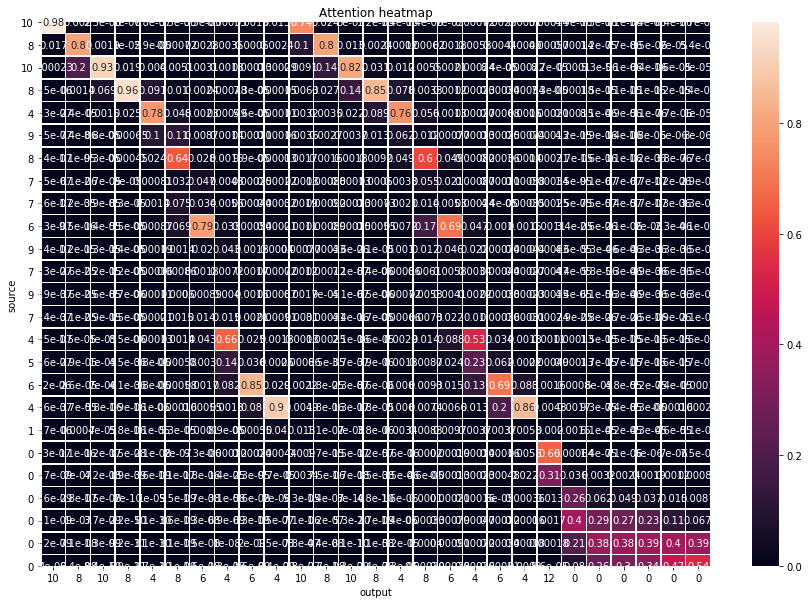

In [15]:
att , predicting_logits_ = sess.run([attention_matrix  , predicting_logits], 
                                     feed_dict = {input_data : train_source_batch ,
                                                  targets : train_target_batch ,
                                                  from_model_or_target : coin_tossing})    

# 隨機取一個樣本 i 畫出注意力矩陣
i = 15
matrix = att[i , : , :]
matrix = matrix[1: , :]
src =  train_source_batch[i, :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(item)
src_letter = src_letter[:-1]   
for item in tgt :
    tgt_letter.append(item)   
print(src_letter)
print(tgt_letter)

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(15 , 10))
ax = sns.heatmap(df , linewidths = 0.5 , annot = True)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()